# Is there really a pause in global warming?
[add intro text here]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from astropy import time
import datetime
import triangle
import george
from george import kernels
import pymultinest
import Fitters
import sys

sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
sns.set_style('ticks')

%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
giss_fname = '/media/ExtraSpace/DataScience/data/Climate/giss_data.dat'
berkeley_fname = '/media/ExtraSpace/DataScience/data/Climate/berkeley_earth.dat'
giss_data = pd.read_fwf(giss_fname, comment='#')
berkeley_data = pd.read_fwf(berkeley_fname, comment='%', skiprows=47)

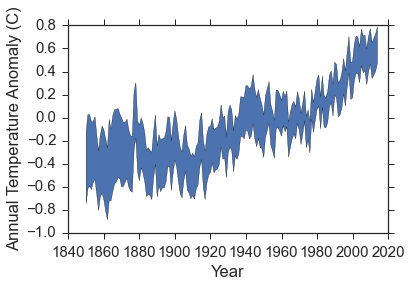

In [3]:
berkeley_data['Anomaly'] = (berkeley_data['Ann1'] + berkeley_data['Ann2'])/2.0
berkeley_data['Anomaly_err'] = np.sqrt((0.5*berkeley_data['Ann1_err'])**2 + (0.5*berkeley_data['Ann2_err']))
plt.fill_between(berkeley_data.Year, berkeley_data.Anomaly+berkeley_data.Anomaly_err, berkeley_data.Anomaly-berkeley_data.Anomaly_err)
plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
outdir = '/home/kgullikson/Dropbox/Ipython_Notebooks/DataScience_Fun/ModelEvidence_blogpost/Figures/'
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.savefig('{}Anomaly_Full.png'.format(outdir))

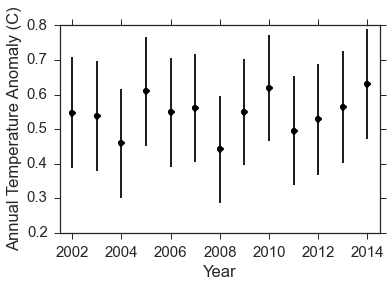

In [4]:
# Make a close-up plot
idx = berkeley_data.Year > 2001
plt.errorbar(berkeley_data.Year.ix[idx], berkeley_data.Anomaly.ix[idx], yerr=berkeley_data.Anomaly_err.ix[idx], fmt='ko')
plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.xlim((2001.5, 2014.5))
plt.savefig('{}Anomaly_Recent.png'.format(outdir))

## Fit using an exponential model

In [5]:
class ExponentialFitter(Fitters.MultiNestFitter):
    def mnest_prior(self, cube, ndim, nparams):
        """
        Put in the priors for the parameters here.
        PyMultinest puts all the parameters as uniform distributions from 0-1. We need to transform
          that into the cumulative distribution function for the prior we want.
        """
        cube[0] = cube[0] - 1 #zero-point: uniform on [-1, 0]
        cube[1] = cube[1]*1000 + 1500  # Exponential turnover time: uniform on [1500, 2500]
        cube[2] = cube[2]*0.1  # Exponential scale factor: uniform on [0, 0.1]
        return
    
    def model(self, pars, t):
        """
        exponential growth model
        """
        zeropoint, t0, scale_factor = pars
        return np.exp(scale_factor*(t-t0)) + zeropoint
    
    


    
    

In [6]:
# Set up MCMC fit
exp_fitter = ExponentialFitter(x=berkeley_data.Year.values, y=berkeley_data.Anomaly.values, 
                              yerr=berkeley_data.Anomaly_err.values, 
                              param_names=['zeropoint', 't0', 'scalefactor'])


In [7]:
# Run the sampler
exp_fitter.fit(overwrite=False, basename='multinest_output/exponential/single-')

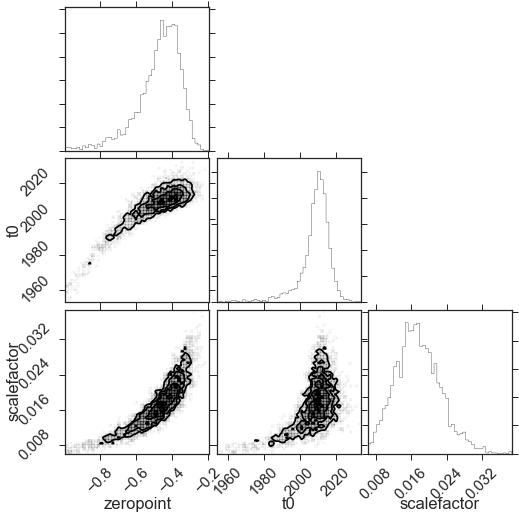

In [8]:
exp_fitter.triangle()

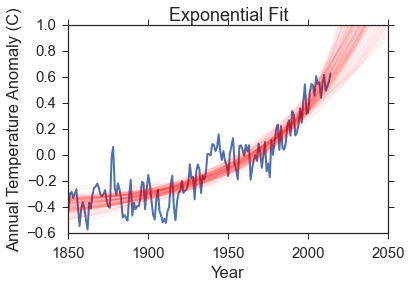

In [9]:
fig, ax = plt.subplots()
ax.plot(berkeley_data.Year, berkeley_data.Anomaly, lw=2)

t_samples = np.arange(1850, 2050, 1)
ax = exp_fitter.plot_samples(t_samples, N=100, ax=ax, alpha=0.05, color='red')
plt.draw()

ax.set_ylim((-0.6, 1))

plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.title('Exponential Fit')
plt.savefig('{}ExpFit.png'.format(outdir))

In [10]:
exp_evidence = exp_fitter.evidence
print('Evidence = {:.2f} +/- {:.2f}'.format(*exp_evidence))

  analysing data from multinest_output/exponential/single-.txt
Evidence = 101.68 +/- 0.10


## Fit using an exponential growth with correlated noise
[discuss correlated noise and gaussian processes]

In [40]:
import george
from george import kernels
class GPFitter(Fitters.MultiNestFitter):
    
    def mnest_prior(self, cube, ndim, nparams):
        """
        Put in the priors for the parameters here.
        PyMultinest puts all the parameters as uniform distributions from 0-1. We need to transform
          that into the cumulative distribution function for the prior we want.
        """
        cube[0] = cube[0]*15 - 10  # ln(a), where a multiplies the GP
        cube[1] = cube[1]*25 - 5   #ln(tau), where tau is the GP scale factor
        return
    
    def model(self, pars, t):
        """
        exponential growth model
        """
        zeropoint, t0, scale_factor = pars
        return np.exp(scale_factor*(t-t0)) + zeropoint
    
    
    def _lnlike(self, pars):
        """
        Over-riding the likelihood function evaluation to use Gaussian Processes.
        """
        y_pred = np.zeros(len(self.x))
 
        a, tau = np.exp(pars)
        gp = george.GP(a * kernels.ExpSquaredKernel(tau), solver=george.HODLRSolver)
        gp.compute(self.x, self.yerr)
        return gp.lnlikelihood(self.y - y_pred)
    
    
    def predict(self, x, N=100, highest=False):
        """
        Need to override the prediction method as well to use Gaussian Processes.
        """
        if self.samples is None:
            logging.warn('Need to run the fit method before predict!')
            return

        # Find the N best walkers
        if N == 'all':
            N = self.samples.shape[0]
        else:
            N = min(N, self.samples.shape[0])

        if highest:
            samples = self.samples.sort('lnprob', ascending=False)[:N]
        else:
            indices = np.random.randint(0, self.samples.shape[0], N)
            samples = self.samples.ix[indices]

        pars = samples[self.param_names].as_matrix()
        y = []
        for i, p in enumerate(pars):
            #print('Generating GP samples for iteration {}/{}'.format(i+1, len(pars)))
            ypred_data = np.zeros(len(self.x))
            ypred = np.zeros(len(x))
            
            a, tau = np.exp(p)
            gp = george.GP(a * kernels.ExpSquaredKernel(tau), solver=george.HODLRSolver)
            gp.compute(self.x, self.yerr)
            s = gp.sample_conditional(self.y - ypred_data, x) + ypred
            y.append(s)
        
        return np.array(y)

In [41]:
# Set up a new sampler
gp_fitter = GPFitter(x=berkeley_data.Year.values, y=berkeley_data.Anomaly.values, 
                                    yerr=berkeley_data.Anomaly_err.values, 
                                    param_names=['lna', 'lntau'])

In [42]:
gp_fitter.fit(overwrite=False, basename='multinest_output/gaussian_process/single-')

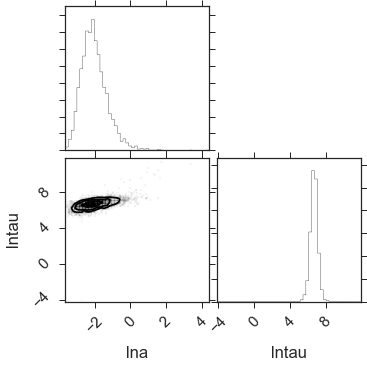

In [43]:
gp_fitter.triangle()

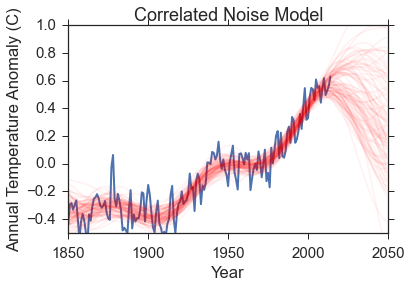

In [44]:
# plot
fig, ax = plt.subplots()
ax.plot(berkeley_data.Year, berkeley_data.Anomaly, lw=2)
ax = gp_fitter.plot_samples(t_samples, N=100, color='red', alpha=0.05, ax=ax)
ax.set_ylim((-0.5, 1))
#ax.set_xlabel('Year')
#ax.set_ylabel('$\Delta T$')


plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.title('Correlated Noise Model')
plt.savefig('{}GaussianProcess.png'.format(outdir))

In [45]:
gp_evidence = gp_fitter.evidence
print('Evidence = {:.2f} +/- {:.2f}'.format(*gp_evidence))

  analysing data from multinest_output/gaussian_process/single-.txt
Evidence = 77.24 +/- 0.03


## Exponential model with warming stop near 2000
[discuss]

In [19]:
class ExponentialStopFitter(Fitters.MultiNestFitter):
    def mnest_prior(self, cube, ndim, nparams):
        """
        Put in the priors for the parameters here.
        PyMultinest puts all the parameters as uniform distributions from 0-1. We need to transform
          that into the cumulative distribution function for the prior we want.
        """
        cube[0] = cube[0] - 1 #zero-point: uniform on [-1, 0]
        cube[1] = cube[1]*1000 + 1500  # Exponential turnover time: uniform on [1500, 2500]
        cube[2] = cube[2]*0.1  # Exponential scale factor: uniform on [0, 0.1]
        cube[3] = cube[3]* 30 + 1990  # When the warming stop occurs
        return
    
    def model(self, pars, t):
        """
        exponential growth model that stops growing at some point
        """
        zeropoint, t0, scale_factor, stop_t = pars
        retval = np.exp(scale_factor*(t-t0)) + zeropoint
        i = np.searchsorted(t, stop_t)
        retval[t>stop_t] = retval[i-1]

        return retval



In [20]:
# Set up a new sampler
estop_fitter = ExponentialStopFitter(x=berkeley_data.Year.values, y=berkeley_data.Anomaly.values, 
                              yerr=berkeley_data.Anomaly_err.values, 
                              param_names=['zeropoint', 't0', 'scalefactor', 'stop_time'])


In [21]:
estop_fitter.fit(overwrite=False, basename='multinest_output/exponential_stop/single-')

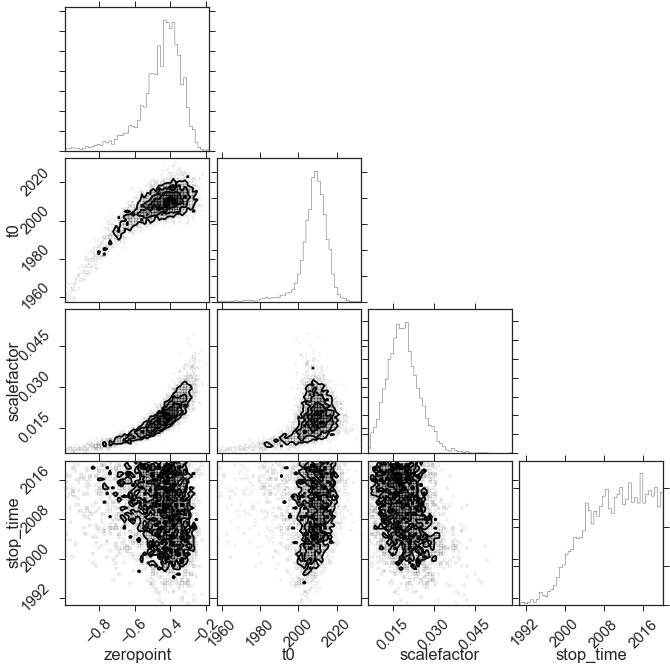

In [22]:
estop_fitter.triangle()

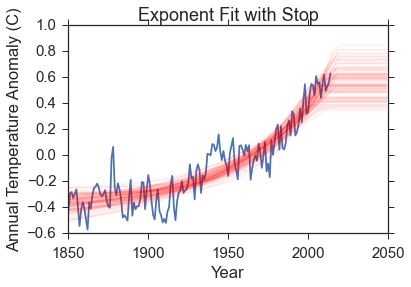

In [23]:
fig, ax = plt.subplots()
ax.plot(berkeley_data.Year, berkeley_data.Anomaly)
ax = estop_fitter.plot_samples(t_samples, ax=ax, N=100, color='red', alpha=0.05)

plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.title('Exponent Fit with Stop')
plt.savefig('{}ExpFit_Stop.png'.format(outdir))

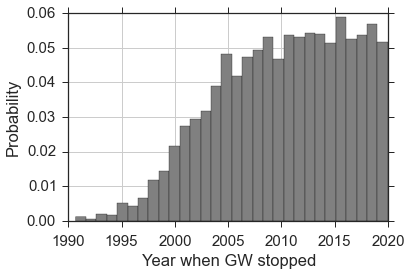

In [24]:
# For this one, also plot the histogram of stopping times
estop_fitter.samples.stop_time.hist(bins=30, color='gray', normed=True)
plt.xlabel('Year when GW stopped')
plt.ylabel('Probability')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.savefig('{}GW_Stoptime.png'.format(outdir))

In [25]:
exp_stop_evidence = estop_fitter.evidence
print('Evidence = {:.2f} +/- {:.2f}'.format(*exp_stop_evidence))

  analysing data from multinest_output/exponential_stop/single-.txt
Evidence = 100.76 +/- 0.06


#Constant model
This is just to show that the evidence can support one model over another.

In [26]:
class ConstantFitter(Fitters.MultiNestFitter):
    def mnest_prior(self, cube, ndim, nparams):
        """
        Put in the priors for the parameters here.
        PyMultinest puts all the parameters as uniform distributions from 0-1. We need to transform
          that into the cumulative distribution function for the prior we want.
        """
        cube[0] = cube[0]*50 - 25 #Intercept
        return
    
    def model(self, pars, t):
        """
        exponential growth model that stops growing at some point
        """
        intercept = pars
        return intercept*np.ones(len(t))

In [27]:
# Set up a new sampler
constant_fitter = ConstantFitter(x=berkeley_data.Year.values, y=berkeley_data.Anomaly.values, 
                              yerr=berkeley_data.Anomaly_err.values, 
                              param_names=['Anomaly'])

In [28]:
constant_fitter.fit(overwrite=False, basename='multinest_output/constant/single-')

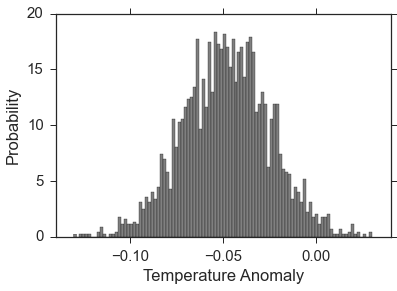

In [29]:
out = plt.hist(constant_fitter.samples.Anomaly, bins=100, color='gray', normed=True)
plt.xlabel('Temperature Anomaly')
plt.ylabel('Probability')

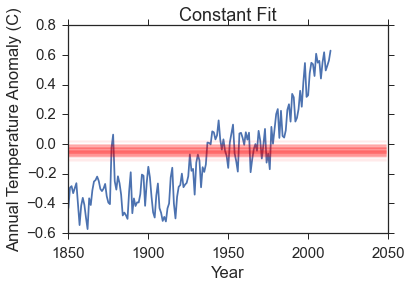

In [30]:
fig, ax = plt.subplots()
ax.plot(berkeley_data.Year, berkeley_data.Anomaly)
ax = constant_fitter.plot_samples(t_samples, ax=ax, N=100, color='red', alpha=0.05)

plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.title('Constant Fit')
plt.savefig('{}Constant.png'.format(outdir))

In [31]:
constant_evidence = constant_fitter.evidence
print('Evidence = {:.2f} +/- {:.2f}'.format(*constant_evidence))

  analysing data from multinest_output/constant/single-.txt
Evidence = 34.11 +/- 0.02


#High order polynomial
To show that very good fits can have low evidence too

In [32]:
class PolynomialFitter(Fitters.MultiNestFitter):
    def __init__(self, **kwargs):
        """ Add x-axis normalization to the initialization for better stability"""
        self.xlow = np.min(kwargs['x'])
        self.xhigh = np.max(kwargs['x'])
        self.normalize = lambda x: (x - (self.xhigh+self.xlow)/2.0) / (self.xhigh - self.xlow)
        super(PolynomialFitter, self).__init__(**kwargs)
        
    def mnest_prior(self, cube, ndim, nparams):
        """
        Put in the priors for the parameters here.
        PyMultinest puts all the parameters as uniform distributions from 0-1. We need to transform
          that into the cumulative distribution function for the prior we want.
        """
        # We will fit for the log of the parameters with log-uniform prior
        cube[0] = cube[0]*2e4 - 1e4
        cube[1] = cube[1]*2e4 - 1e4
        cube[2] = cube[2]*2e4 - 1e4
        cube[3] = cube[3]*2e4 - 1e4
        cube[4] = cube[4]*2e4 - 1e4
        cube[5] = cube[5]*2e4 - 1e4
        #cube[6] = cube[6]*8-4
        #cube[7] = cube[7]*8-4
        #cube[8] = cube[8]*8-4
        #cube[9] = cube[9]*8-4
        #cube[10] = cube[10]*8-4
        
        return
    
    def model(self, pars, t):
        """
        exponential growth model that stops growing at some point
        """
        #polypars = 10**np.array(pars)
        polypars = pars
        return np.poly1d(polypars)(self.normalize(t))

In [33]:
# Set up a new sampler
names = ['c{}'.format(i) for i in range(5, -1, -1)]
poly_fitter = PolynomialFitter(x=berkeley_data.Year.values, y=berkeley_data.Anomaly.values, 
                              yerr=berkeley_data.Anomaly_err.values, 
                              param_names=names)

In [34]:
poly_fitter.fit(overwrite=False, basename='multinest_output/polynomial/single-')

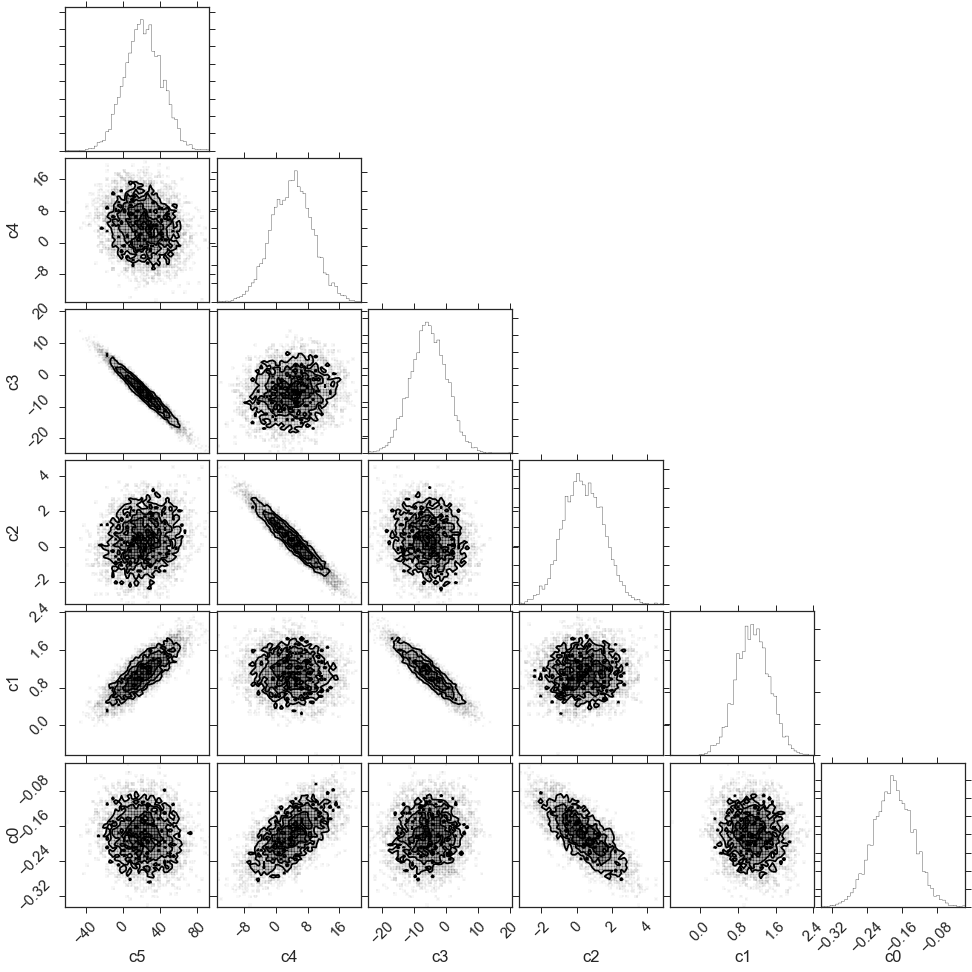

In [35]:
poly_fitter.triangle()

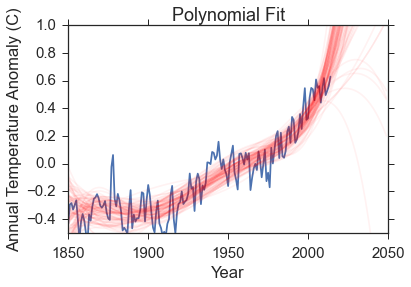

In [36]:
fig, ax = plt.subplots()
ax.plot(berkeley_data.Year, berkeley_data.Anomaly)
ax = poly_fitter.plot_samples(t_samples, ax=ax, N=100, color='red', alpha=0.05)
ax.set_ylim((-0.5, 1))

plt.xlabel('Year')
plt.ylabel('Annual Temperature Anomaly (C)')
plt.subplots_adjust(left=0.16, bottom=0.18)
plt.title('Polynomial Fit')
plt.savefig('{}Polynomial.png'.format(outdir))

In [37]:
poly_evidence = poly_fitter.evidence
print('Evidence = {:.2f} +/- {:.2f}'.format(*poly_evidence))

  analysing data from multinest_output/polynomial/single-.txt
Evidence = 55.01 +/- 0.01


In [46]:
# Summarize the evidence
print('Exponential Model Evidence = {:.2f} +/- {:.2f}'.format(*exp_evidence))
print('Exponential Model with GW Stop Evidence = {:.2f} +/- {:.2f}'.format(*exp_stop_evidence))
print('Noise model Evidence = {:.2f} +/- {:.2f}'.format(*gp_evidence))
print('Constant Model Evidence = {:.2f} +/- {:.2f}'.format(*constant_evidence))
print('High order polynomial Model Evidence = {:.2f} +/- {:.2f}\n\n'.format(*poly_evidence))

# Evidence ratios
def ev_ratio(model1, model2):
    R = np.exp(model1[0] - model2[0])
    R_var = ((model1[0] - model2[0])*R)**2 * (model1[1]**2 + model2[1]**2)
    return R, np.sqrt(R_var)
print('Constant to Polynomial Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(constant_evidence, poly_evidence)))
print('Constant to Exponential Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(constant_evidence, exp_evidence)))
print('Constant to Exponential-Stop Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(constant_evidence, exp_stop_evidence)))
print('Constant to Noise Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(constant_evidence, gp_evidence)))
print('Polynomial to Exponential Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(poly_evidence, exp_evidence)))
print('Polynomial to Exponential-Stop Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(poly_evidence, exp_stop_evidence)))
print('Polynomial to Noise Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(poly_evidence, gp_evidence)))
print('Exponential to Exponential-Stop Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(exp_evidence, exp_stop_evidence)))
print('Exponential to Noise Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(exp_evidence, gp_evidence)))
print('Exponential-stop to Noise Evidence Ratio = {:.4g} +/- {:.4g}'.format(*ev_ratio(exp_stop_evidence, gp_evidence)))

Exponential Model Evidence = 101.68 +/- 0.10
Exponential Model with GW Stop Evidence = 100.76 +/- 0.06
Noise model Evidence = 77.24 +/- 0.03
Constant Model Evidence = 34.11 +/- 0.02
High order polynomial Model Evidence = 55.01 +/- 0.01


Constant to Polynomial Evidence Ratio = 8.401e-10 +/- 3.212e-10
Constant to Exponential Evidence Ratio = 4.521e-30 +/- 3.073e-29
Constant to Exponential-Stop Evidence Ratio = 1.139e-29 +/- 4.696e-29
Constant to Noise Evidence Ratio = 1.856e-19 +/- 3.045e-19
Polynomial to Exponential Evidence Ratio = 5.382e-21 +/- 2.508e-20
Polynomial to Exponential-Stop Evidence Ratio = 1.356e-20 +/- 3.763e-20
Polynomial to Noise Evidence Ratio = 2.209e-10 +/- 1.771e-10
Exponential to Exponential-Stop Evidence Ratio = 2.52 +/- 0.2701
Exponential to Noise Evidence Ratio = 4.104e+10 +/- 1.056e+11
Exponential-stop to Noise Evidence Ratio = 1.629e+10 +/- 2.651e+10
